In [2]:
from pathlib import Path
from tqdm import tqdm
import networkx as nx

import requests
from bs4 import BeautifulSoup as bs
import concurrent.futures

from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt

from ffmpeg import FFmpeg

In [3]:
metadata = Path('metadata')
graphs = Path('graph')
videos = Path('videos')
tables = Path('tables')

for folder in [metadata, graphs, tables]:
    if not folder.exists():
        folder.mkdir(parents=True)


# Progresso

| Variável/Frequência                        	| Anual 	| Decenal 	|
|-----------------------------------	|-------	|---------	|
| Quantidade de filmes              	| ✅     	| ✅       	|
| Quantidade de diretores           	| ✅     	| ✅       	|
| Diversidade de direção            	| ✅     	| ✅       	|
| Quantidade de atores              	| ✅     	| ✅       	|
| Parceria entre diretores e atores 	| ✅      	| ✅        	|
| Gêneros                           	| ✅   	    | ✅     	|

# Coleta de informações

In [4]:
headers = {
    'Host': 'www.imdb.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
    'Accept-Language': 'pt-BR,pt;q=0.8,en-US;q=0.5,en;q=0.3',
    'Accept-Encoding': 'gzip, deflate, br',
    'DNT': '1',
    'Alt-Used': 'www.imdb.com',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'none',
    'Sec-Fetch-User': '1',
}

params = {
    'title_type': 'feature',
    'release_date': '',
    'sort': 'moviemeter,asc',
    'country_of_origin': 'BR',
}

main_URL = 'https://www.imdb.com/search/title/'

## Os 50 filmes mais populares de cada ano

In [5]:
if not Path(metadata/'metadata.csv').exists():

    movies_list = []

    for year in range(1970, 2024):
        
        date = (
            ','.join(
                [f'{year}-01-01',
                f'{year+1}-01-01']
                )
            )
        params['release_date'] = date
        r = requests.get(main_URL, params=params, headers=headers)
        soup = bs(r.text, 'html.parser')

        for movie in soup.find_all('li', {'class': 'ipc-metadata-list-summary-item'}):
            movie_URL = (
                movie
                .find('a', {'class': 'ipc-title-link-wrapper'})
                .get('href')
                )
            movie_ID = movie_URL.split('/')[2]
            movies_list.append(movie_ID)

## Informações de cada filme

In [6]:
def get_movie_info(movie_ID):

    def get_movie_title(soup):
        return soup.find('h1').text
    
    def get_movie_rating(soup):
        try:
            rating = (
                soup
                .find('div', {'data-testid': 'hero-rating-bar__aggregate-rating__score'})
                .text
                .replace(',', '.')
                .split('/')
                [0]
                )
            return rating
        except AttributeError as no_rating:
            return None

    def get_movie_year(soup):
        try:
            for tag in movie_soup.find_all('a', {'class': 'ipc-link ipc-link--baseAlt ipc-link--inherit-color'}):
                if 'releaseinfo' in tag.get('href'):
                    return tag.text
        except AttributeError as no_year_found:
            return None

    def get_movie_genres(soup):
        try:
            g = soup.find('div', {'class': 'ipc-chip-list__scroller'})
            return [genre.text for genre in g]
        except TypeError as no_genres:
            return None

    def get_director(soup):
        try:
            d = soup.find_all('table', {'class': 'simpleTable simpleCreditsTable'})[0].find_all('a')
            return [director.text.strip() for director in d]
        except IndexError:
            return None

    def get_duration(soup):
        try:
            duration = (
                soup
                .find('li', {'data-testid': 'title-techspec_runtime'})
                .find('div')
                .text
                )
            try:
                hour, _, minutes, _ = duration.split()
                duration_normalized = (int(hour) * 60) + int(minutes)
            except ValueError as only_minutes:
                minutes, _ = duration.split()
                duration_normalized = int(minutes)
            
            return duration_normalized
        except AttributeError as no_duration_info:
            return None
        
        
    
    def get_writers(soup):
        try:
            w = (
                soup
                .find_all('table', {'class': 'simpleTable simpleCreditsTable'})
                [1]
                .find_all('td', {'class': 'name'})
                )
            
            return [writer.text.strip() for writer in w]
        except IndexError as no_writers:
            return None
    
    def get_actors(soup):
        actors = []
        try:
            a = (
                soup
                .find_all('table', {'class': 'cast_list'})
                [0]
                .find_all('a')
                )
            
            for actor in a:
                try:
                    actor_name = actor.find('img').get('title')
                    actors.append(actor_name)
                except AttributeError as no_title_name:
                    pass
        except IndexError as no_actors:
            return None
        
        return actors


    movie_URL = 'https://www.imdb.com/title/' + movie_ID
    movie_r = requests.get(movie_URL, headers=headers)
    movie_soup = bs(movie_r.text, 'html.parser')

    credits_URL = movie_URL + '/fullcredits'
    credits_r = requests.get(credits_URL, headers=headers)
    credits_soup = bs(credits_r.text, 'html.parser')

    info = {
        'movie_ID': movie_ID,
        'movie_URL': movie_URL,
        'movie_title': get_movie_title(movie_soup),
        'movie_rating': get_movie_rating(movie_soup),
        'movie_year': get_movie_year(movie_soup),
        'movie_genres': get_movie_genres(movie_soup),
        'movie_duration': get_duration(movie_soup),

        'credits_URL': credits_URL,
        'directed_by': get_director(credits_soup),
        'written_by': get_writers(credits_soup),
        'actors': get_actors(credits_soup),
    }
    
    return info

In [7]:
if not Path(metadata/'metadata.csv').exists():
    ds = []
    
    for movie_ID in movies_list:
        ds.append(get_movie_info(movie_ID))

    df = pd.DataFrame(ds)
    df.to_csv(metadata / 'metadata.csv', index=False)
else:
    df = pd.read_csv(metadata / 'metadata.csv')

In [8]:
# Alguns valores podem ser corrigidos depois de verificação manual

df.loc[df['movie_ID'] == 'tt12325302', 'movie_year'] = 2019
df[df['movie_ID'] == 'tt12325302']

,movie_ID,movie_URL,movie_title,movie_rating,movie_year,movie_genres,movie_duration,credits_URL,directed_by,written_by,actors
2224,tt12325302,https://www.imdb.com/title/tt12325302,Luccas Neto em: Acampamento de Férias,2.7,2019.0,"['Comédia', 'Família']",87.0,https://www.imdb.com/title/tt12325302/fullcredits,['Lucas Margutti'],['Gabriel Piedro'],"['Giovanna Alparone', 'João Gabriel Pessanha C..."


In [9]:
df['movie_year'] = (
    df['movie_year']
    .fillna(0)
    .astype(int)
    .astype(str)
    .apply(lambda x: x.zfill(4))
)

df['movie_decade'] = df['movie_year'].apply(lambda year: year[:3] + '0')

In [10]:
df[['movie_ID']].to_csv(tables / 'movie_IDs.csv', index=False)
df[['movie_ID', 'movie_title']].to_csv(tables / 'movie_titles_IDS.csv', index=False)

# Visualização de dados

## Quantidade de filmes por período de tempo
### Por ano

<Axes: title={'center': 'Quantos filmes brasileiros foram lançados por ano, segundo IMDb'}, xlabel='Ano de lançamento', ylabel='Quantidade de filmes'>

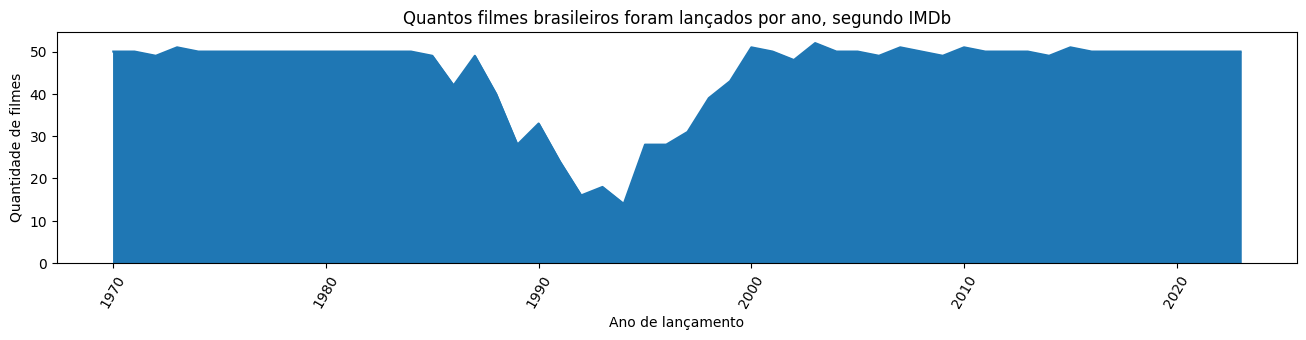

In [11]:
(
    df
    .groupby('movie_year')
    ['movie_ID']
    .count()
    .plot(
        title='Quantos filmes brasileiros foram lançados por ano, segundo IMDb',
        ylabel='Quantidade de filmes',
        xlabel='Ano de lançamento',
        kind='area',
        figsize=(16,3),
        rot=60
        )
)

### Por década

<Axes: title={'center': 'Quantos filmes brasileiros foram lançados por década, segundo IMDb'}, xlabel='Ano de lançamento', ylabel='Quantidade de filmes'>

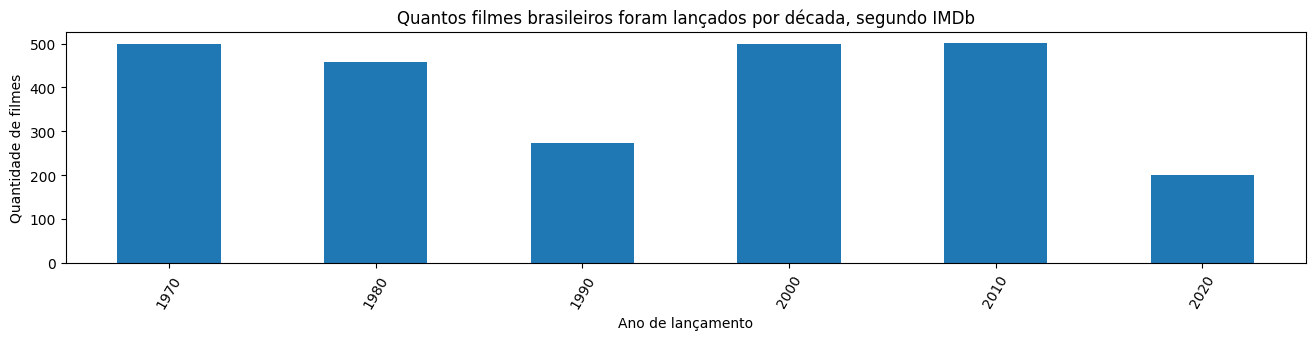

In [12]:
(
    df
    .groupby('movie_decade')
    ['movie_ID']
    .count()
    .reindex(['1970', '1980', '1990', '2000', '2010', '2020'])
    .plot(
        title='Quantos filmes brasileiros foram lançados por década, segundo IMDb',
        ylabel='Quantidade de filmes',
        xlabel='Ano de lançamento',
        kind='bar',
        figsize=(16,3),
        rot=60
        )
)

## Diretores
### Geral

In [13]:
movie_directors = df[['movie_ID', 'directed_by']].dropna()

movie_directors['directed_by'] = movie_directors['directed_by'].apply(literal_eval)

In [14]:
(
    movie_directors
    .explode('directed_by')
    .to_csv(tables / 'movie_directors.csv', index=False)
)

<Axes: title={'center': 'Diretores com mais filmes dirigidos nos últimos anos.'}>

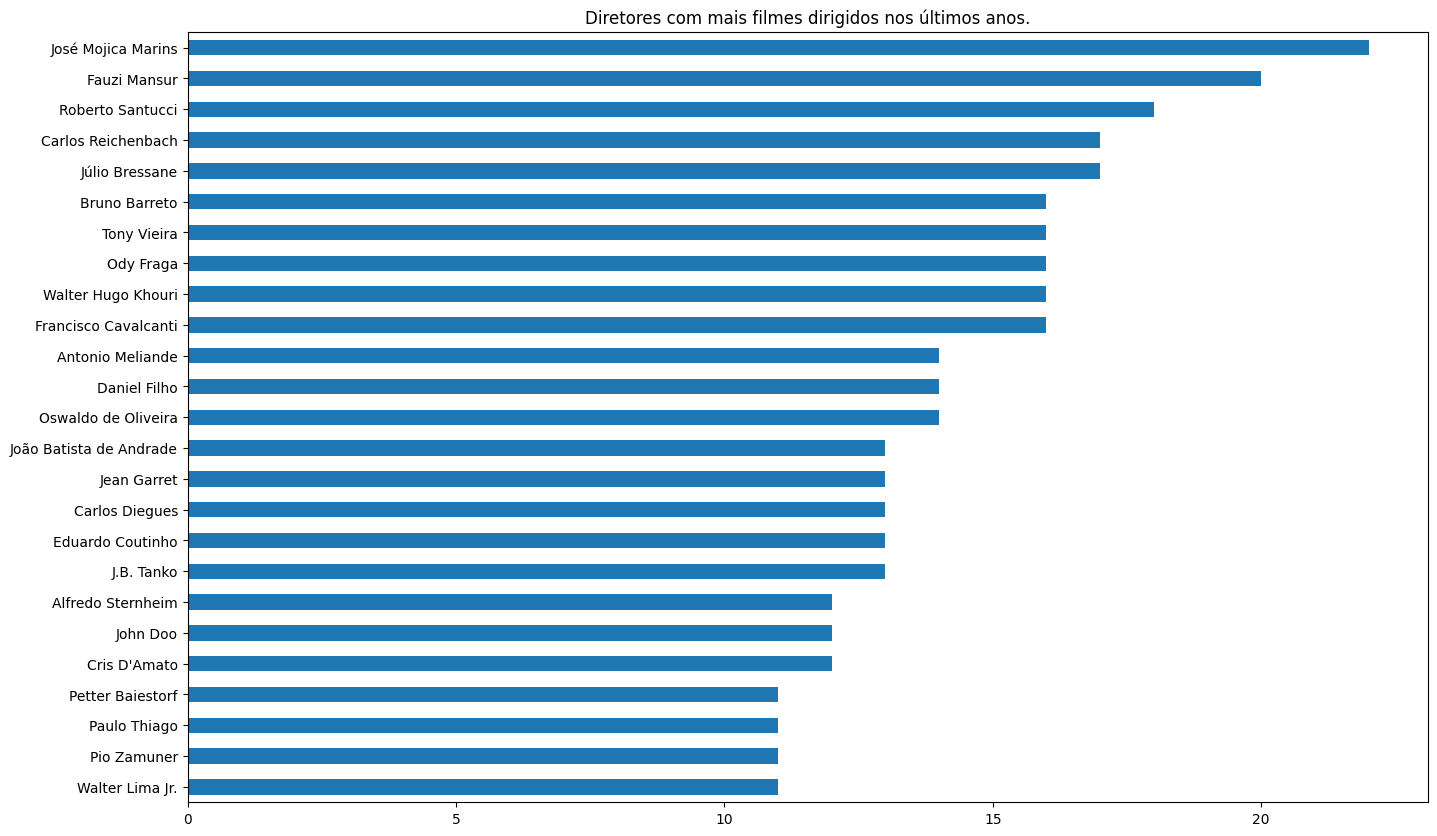

In [15]:
(
    df['directed_by']
    .dropna()
    .apply(literal_eval)
    .explode()
    .value_counts()
    .head(25)
    .sort_values()
    .plot(
        kind='barh',
        figsize=(16,10),
        title='Diretores com mais filmes dirigidos nos últimos anos.'
        )
)

### Por década

In [16]:
directors_decade = (
    df[['directed_by', 'movie_ID', 'movie_decade']]
    .dropna(subset=['directed_by'])
    .reset_index(drop=True)
    )

directors_decade['directed_by'] = directors_decade['directed_by'].apply(lambda x: literal_eval(x))

directors_decade = directors_decade.explode('directed_by')

In [17]:
top_directors_by_decade = {
    # Década : DataFrame de quantidade de filmes por diretor na década
}

for decade, df_decade in (
    directors_decade
    .groupby(['movie_decade', 'directed_by'])
    .count()
    .sort_values(['movie_decade', 'movie_ID'], ascending=True)
    .groupby('movie_decade')
    ):
    top_directors_by_decade[decade] = df_decade.tail(10).reset_index()

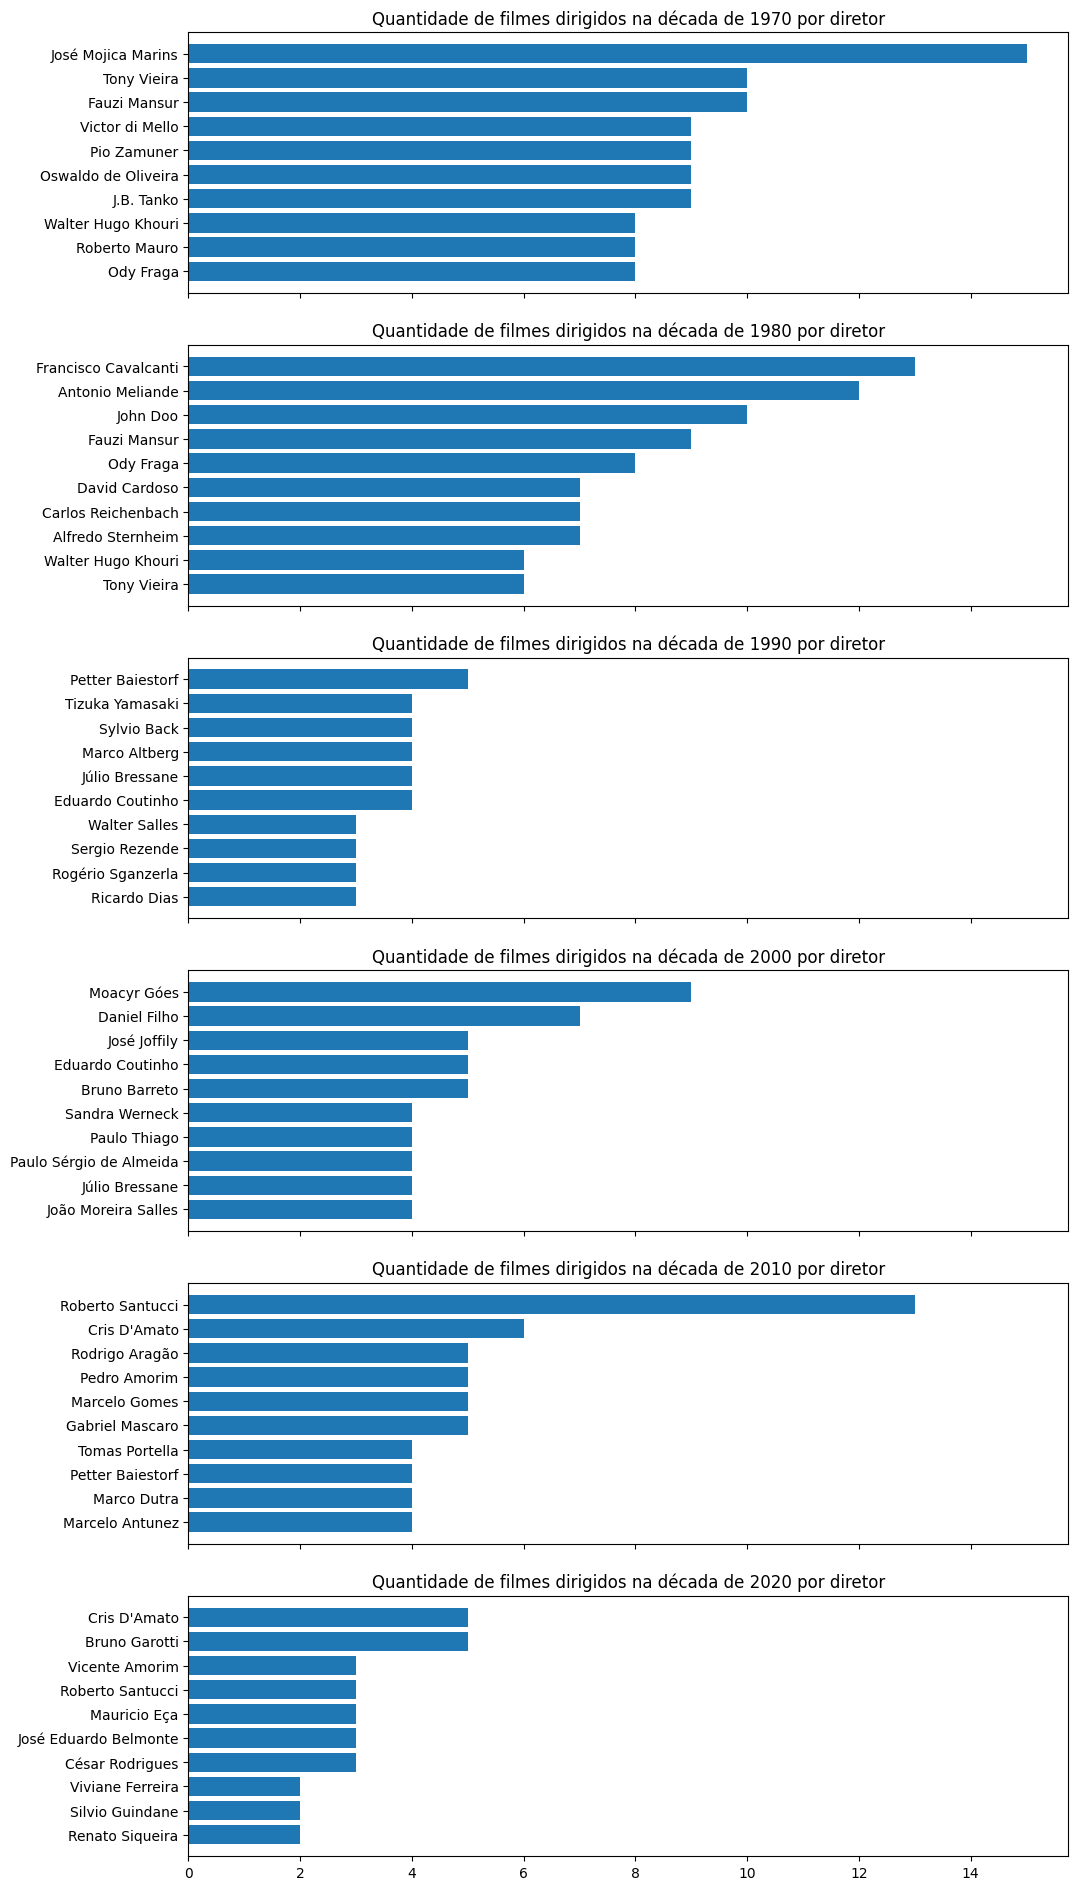

In [18]:
fig, axs = plt.subplots(6, sharex=True)
fig.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.5, top=3.9, wspace=0.2, hspace=0.2)

for i, (key, value) in enumerate(top_directors_by_decade.items()):
    axs[i].title.set_text(f'Quantidade de filmes dirigidos na década de {key} por diretor')
    axs[i].barh(
        top_directors_by_decade[key]['directed_by'],
        top_directors_by_decade[key]['movie_ID']
        )

## Diversidade de direção

### Por ano

In [19]:
directors_years = (
    df[['movie_year', 'directed_by']]
    .dropna(subset=['directed_by'])
)

directors_years['directed_by'] = directors_years['directed_by'].apply(lambda x: literal_eval(x))

<Axes: title={'center': 'Quantidade de diretores diferentes presentes por ano'}, xlabel='movie_year'>

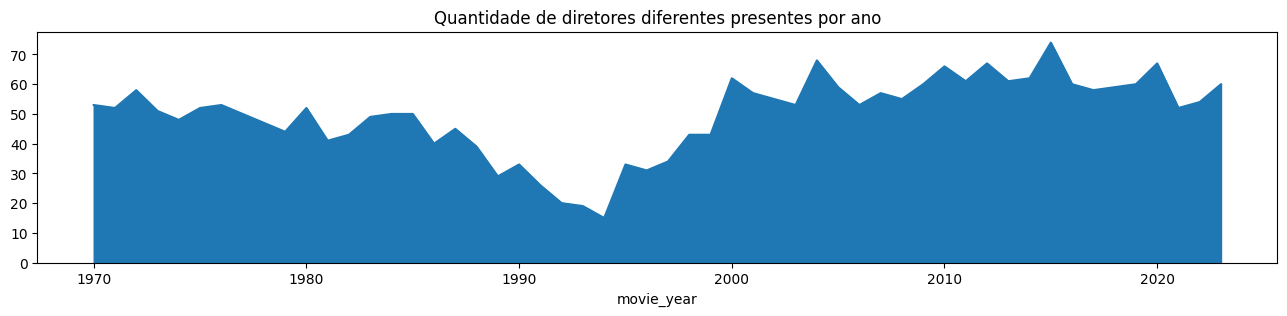

In [20]:
(
    directors_years
    .explode('directed_by')
    .reset_index(drop=True)
    .groupby('movie_year')
    ['directed_by']
    .apply(set)
    .apply(len)
    .plot(
        title='Quantidade de diretores diferentes presentes por ano',
        kind='area',
        figsize=(16,3),
        rot=0
    )
)

### Por década

<Axes: title={'center': 'Quantidade de diretores diferentes presentes por década'}, xlabel='movie_decade'>

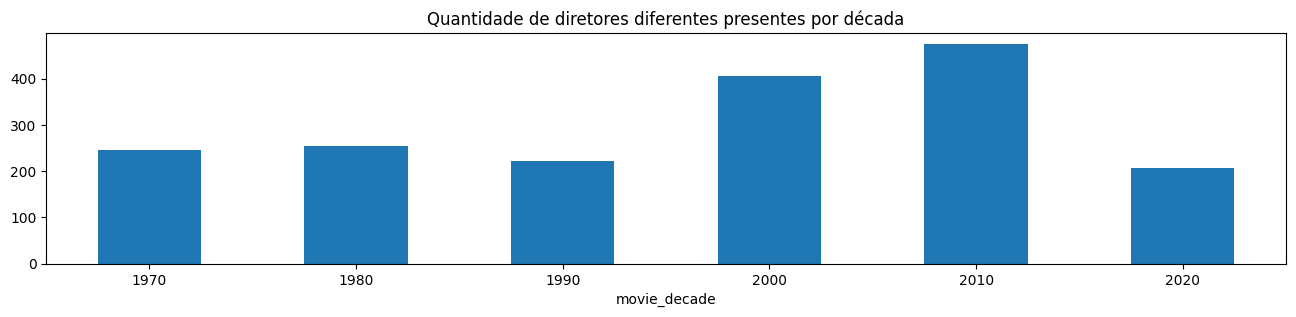

In [21]:
(
    directors_decade
    .reset_index(drop=True)
    .groupby('movie_decade')
    ['directed_by']
    .apply(set)
    .apply(len)
    .plot(
        title='Quantidade de diretores diferentes presentes por década',
        kind='bar',
        figsize=(16,3),
        rot=0
        )
)

## Atores
### Mais presentes no período

In [22]:
movie_actors = df[['movie_ID', 'actors']].dropna()

movie_actors['actors'] = movie_actors['actors'].apply(literal_eval)

In [23]:
(
    movie_actors
    .explode('actors')
    .reset_index(drop=True)
    .to_csv(tables / 'movie_actors.csv', index=False)
)

In [34]:
(    df['actors']
    .dropna()
    .apply(literal_eval)
    .explode()
    .value_counts(ascending=False)
    .head(25)
)

Wilson Grey           83
Sérgio Hingst         71
Paulo César Peréio    57
Otávio Augusto        53
Tonico Pereira        53
Jofre Soares          49
Othon Bastos          46
José Lewgoy           45
Milhem Cortaz         45
Marthus Mathias       44
Rodolfo Arena         43
Milton Gonçalves      42
Nildo Parente         42
Cavagnole Neto        42
José Wilker           42
Sérgio Mamberti       40
Hugo Carvana          40
Monique Lafond        39
Maurício do Valle     39
Renato Aragão         38
Chico Díaz            38
Antonio Pitanga       38
Antonio Pedro         38
Dedé Santana          37
Zezé Motta            37
Name: actors, dtype: int64

<Axes: title={'center': 'Atores mais presentes nos últimos anos.'}>

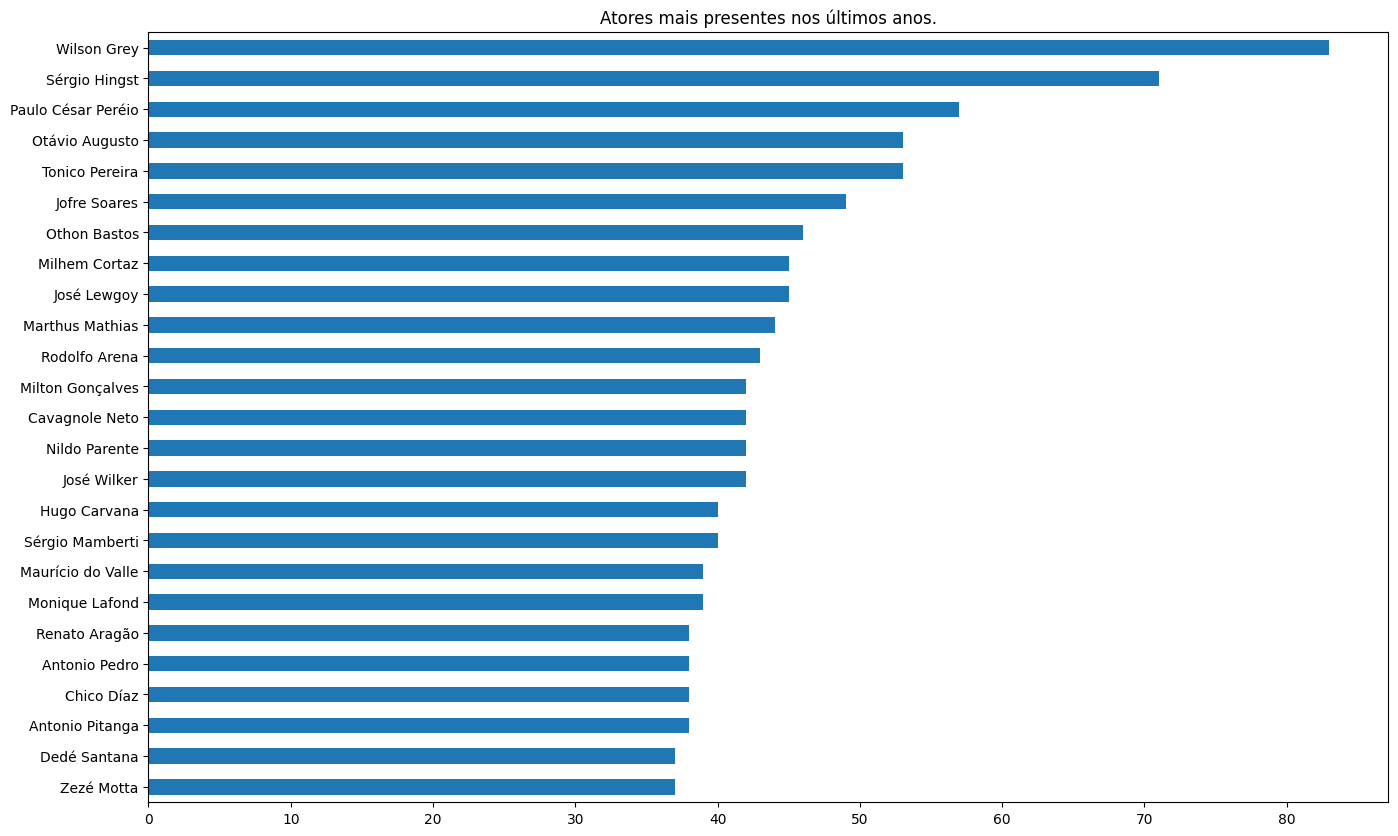

In [25]:
(
    df['actors']
    .dropna()
    .apply(literal_eval)
    .explode()
    .value_counts(ascending=True)
    .tail(25)
     .plot(
        kind='barh',
        figsize=(16,10),
        title='Atores mais presentes nos últimos anos.'
    )
)

### Mais presentes por década

In [26]:
actors_years = (
    df[['movie_decade', 'actors']]
    .dropna(subset=['actors'])
)

actors_years['actors'] = actors_years['actors'].apply(lambda x: literal_eval(x))

<Axes: title={'center': 'Quantidade de atores diferentes presentes por década.'}, xlabel='movie_decade'>

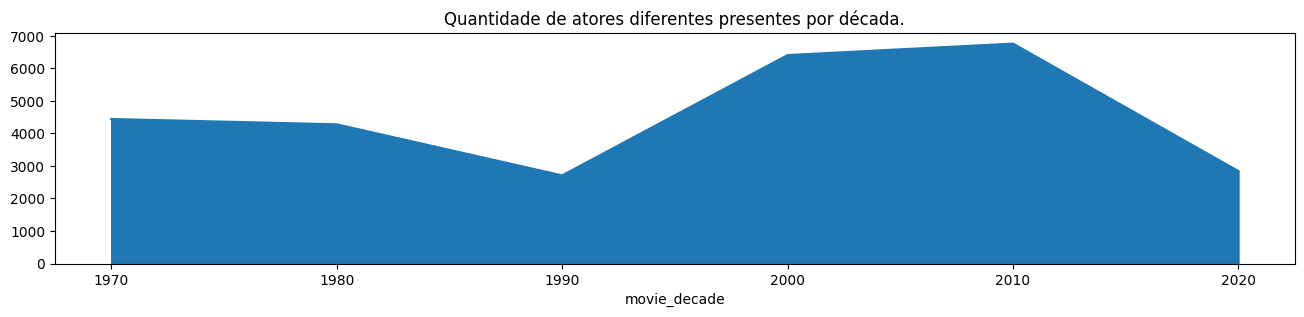

In [27]:
(
    actors_years
    .explode('actors')
    .reset_index(drop=True)
    .groupby('movie_decade')
    ['actors']
    .apply(set)
    .apply(len)
    .plot(
        title='Quantidade de atores diferentes presentes por década.',
        kind='area',
        figsize=(16,3),
        rot=0
    )
)

## Parcerias entre diretores e atores

In [28]:
df_ad = (
    df[
        (~df['actors'].isna())
        &
        (~df['directed_by'].isna())
    ]
    [['movie_ID', 'directed_by', 'actors', 'movie_decade']]
)

df_ad['actors'] = df_ad['actors'].apply(lambda x: literal_eval(x))
df_ad['directed_by'] = df_ad['directed_by'].apply(lambda x: literal_eval(x))

df_ad = df_ad.explode('actors')
df_ad = df_ad.explode('directed_by')

In [29]:
directors_actors_network = (
    df_ad
    .groupby(['movie_decade', 'directed_by', 'actors'])
    ['movie_ID']
    .count()
    .reset_index()
    .sort_values('movie_ID', ascending=False)
    .query('directed_by != actors')
    .rename(columns={
        'directed_by': 'source',
        'actors' :'target',
        'movie_ID': 'weight'
        })
)

### Redes

In [30]:
for movie_decade, t_df in directors_actors_network.groupby('movie_decade'):
    decade_graph = nx.from_pandas_edgelist(
        t_df,
        source='source',
        target='target',
        edge_attr=True
        )
    
    nx.write_graphml(decade_graph, graphs / f'network_graph_{movie_decade}.graphml')

## Gêneros
### Geral

In [31]:
movie_genre = (
    df[['movie_ID', 'movie_genres', 'movie_year', 'movie_decade']]
    .dropna()
    .reset_index(drop=True)
    )

movie_genre['movie_genres'] = movie_genre['movie_genres'].apply(literal_eval)
    
movie_genre

,movie_ID,movie_genres,movie_year,movie_decade
0,tt0195063,"[Drama, Família]",1970,1970
1,tt0122329,[Drama],1970,1970
2,tt0062690,"[Drama, Terror]",1970,1970
3,tt0064863,"[Aventura, Policial, Drama]",1970,1970
4,tt0064582,[Drama],1970,1970
...,...,...,...,...
2358,tt9422624,"[Policial, Suspense]",2023,2020
2359,tt9125246,[Musical],2023,2020
2360,tt27856735,[Drama],2023,2020
2361,tt21650856,[Comédia],2023,2020


In [32]:
(
    movie_genre
    .explode('movie_genres')
    .to_csv(tables / 'movie_genres.csv', index=False)
)

In [33]:
(
    df['movie_genres']
    .dropna()
    .apply(literal_eval)
    .explode()
    .value_counts()
    .head(25)
)

Drama                1099
Comédia               653
Documentário          379
Policial              198
Romance               169
Aventura              135
Família               134
Musical               112
Suspense              109
Terror                108
Biografia             103
Ação                   83
Fantasia               73
Mistério               52
História               48
Animação               43
Faroeste               26
Esportes               20
Ficção científica      20
Guerra                  9
Name: movie_genres, dtype: int64